# Find and Highlight the Maximum Common Substructure Between a Set of Molecules Using RDKit

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-10-09-RDKit-find-and-highlight-the-maximum-common-substructure-between-molecules.ipynb)*

When analyzing a set of molecules, you might want to find the maximum common substructure (MCS) match between them. This utility function `SmilesMCStoGridImage` does that for a set of molecules specified by [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), displays the [SMARTS](https://en.wikipedia.org/wiki/SMILES_arbitrary_target_specification) substructure as a molecule, and displays all the molecules in a grid with that substructure highlighted and aligned.

The key RDKit commands it uses are:
- [`FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to find the maximum common substructure (SMARTS string)
- [`MolFromSmarts`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) to generate a molecule corresponding to the maximum common substructure
- [`GenerateDepictionMatching2DStructure`](http://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html) to align the matching substructure
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) to draw the grid of the MCS, and the molecules with that MCS highlighted

In [24]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS

In [25]:
def SmilesMCStoGridImage(molecules, align_substructure=True, verbose=False, **kwargs):
     """
     Convert a list (or dictionary) of SMILES strings to an RDKit grid image of the maximum common substructure (MCS) match between them

     :returns: RDKit grid image, and (if verbose=True) MCS SMARTS string and molecule, and list of molecules for input SMILES strings
     :rtype: RDKit grid image, and (if verbose=True) string, molecule, and list of molecules
     :param molecules: The SMARTS molecules to be compared and drawn
     :type molecules: List of (SMARTS) strings, or dictionary of (SMARTS) string: (legend) string pairs
     :param align_substructure: Whether to align the MCS substructures when plotting the molecules; default is True
     :type align_substructure: boolean
     :param verbose: Whether to return verbose output (MCS SMARTS string and molecule, and list of molecules for input SMILES strings); default is False so calling this function will present a grid image automatically
     :type verbose: boolean
     """
     mols = [Chem.MolFromSmiles(smile) for smile in molecules]
     res = rdFMCS.FindMCS(mols, **kwargs)
     mcs = res.smartsString
     mcs_mol = Chem.MolFromSmarts(res.smartsString)
     smarts = res.smartsString
     smart_mol = Chem.MolFromSmarts(smarts)
     smarts_and_mols = [smart_mol] + mols

     smarts_legend = "Max. substructure match"

     # If user supplies a dictionary, use the values as legend entries for molecules
     if isinstance(molecules, dict):
          mol_legends = [molecules[molecule] for molecule in molecules]
     else:
          mol_legends = ["" for mol in mols]

     legends =  [smarts_legend] + mol_legends
    
     matches = [""] + [mol.GetSubstructMatch(mcs_mol) for mol in mols]

     subms = [x for x in smarts_and_mols if x.HasSubstructMatch(mcs_mol)]

     Chem.Compute2DCoords(mcs_mol)

     if align_substructure:
          for m in subms:
               _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

     drawing = Draw.MolsToGridImage(smarts_and_mols, highlightAtomLists=matches, legends=legends)

     if verbose:
          return drawing, mcs, mcs_mol, mols
     else:
          return drawing

## Minimal Example

All you have to provide to `SmilesMCStoGridImage` is a lis of SMILES strings, and it will return a grid image:

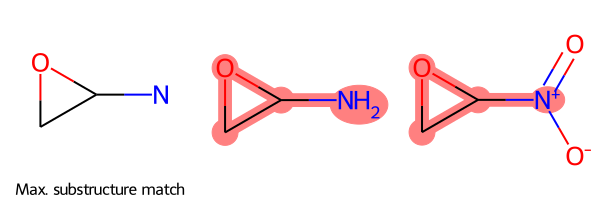

In [26]:
SmilesMCStoGridImage(["NC1OC1", "C1OC1[N+](=O)[O-]"])

If there is no common substructure, the first cell in the grid will be empty (because there is no SMARTS match), and the molecules will be displayed without any highlighting:

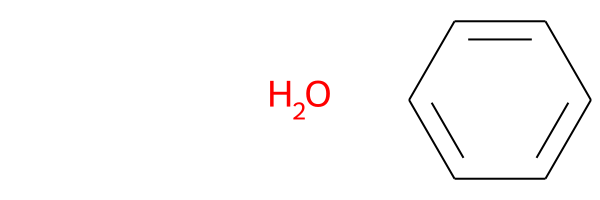

In [27]:
SmilesMCStoGridImage(["O", "c1ccccc1"])

## Label Molecules

If you want to label the molecules in the grid image, provide a *dictionary* of molecules where each
- key is the SMILES string for that molecule
- value is the legend for that molecule, for example its name or a description

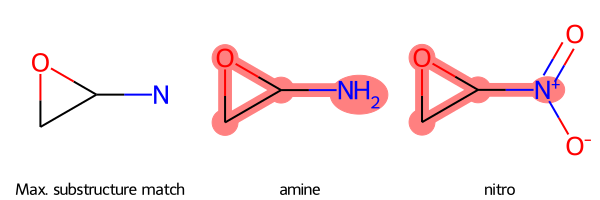

In [28]:
SmilesMCStoGridImage({"NC1OC1": "amine", "C1OC1[N+](=O)[O-]": "nitro"})

## Get Additional Data

If you want `SmilesMCStoGridImage` to return not just the grid image, but also the substructure match and molecule, plus the molecules for the SMILES strings, set `verbose=True`:

In [29]:
drawing, mcs, mcs_mol, mols = SmilesMCStoGridImage({"NC1OC1": "amine", "C1OC1[N+](=O)[O-]": "nitro"}, verbose=True)

You then must explicitly call the image to draw it:

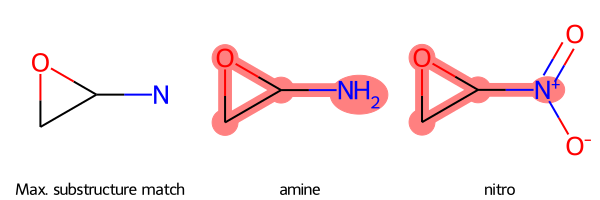

In [30]:
drawing

`mcs` is the SMARTS string for the maximum common substructure (MCS):

In [31]:
mcs

'[#7]-[#6]1-[#8]-[#6]-1'

`mcs_mol` is the molecular representation of that MCS:

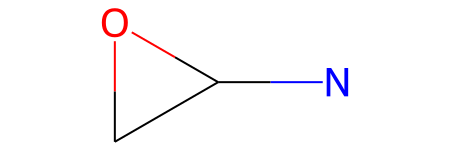

In [32]:
mcs_mol

`mols` is the list of RDKit molecules:

In [33]:
mols

You can plot each molecule, with the MCS highlighted, by indexing the molecule in `mols`:

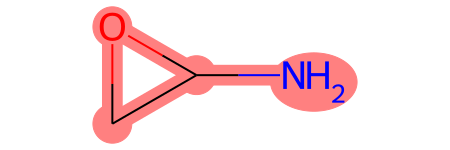

In [34]:
mols[0]

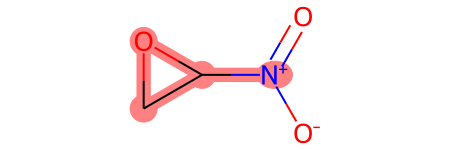

In [35]:
mols[1]

## Caveat About Aligning Maximum Common Substructure
The SMARTS substructure match may not match the form of the molecule. For example, if you input two six-membered carbon rings, the SMARTS substructure match is a linear chain of six carbons. So if you align the molecules to that substructure, you will get some odd-looking "rings":

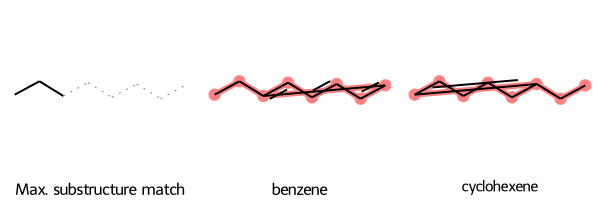

In [36]:
SmilesMCStoGridImage({"CCc1ccccc1": "benzene", "C1CCCC=C1CC": "cyclohexene"})

To address this case, in `SmilesMCStoGridImage` you can set `align_substructure=False` (its default value is `True`), with the disadvantage that the molecules may not be aligned:

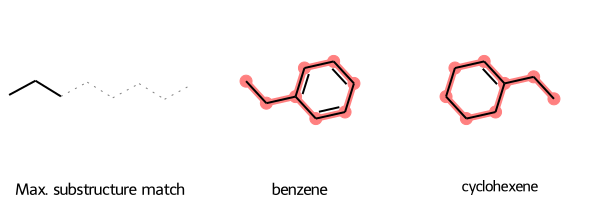

In [37]:
SmilesMCStoGridImage({"CCc1ccccc1": "benzene", "C1CCCC=C1CC": "cyclohexene"}, align_substructure=False)

## Pass Arguments to FindMCS
`SmilesMCStoGridImage` will pass any keyword arguments of [`rdFMCS.FindMCS`](https://www.rdkit.org/docs/source/rdkit.Chem.rdFMCS.html) to that function. For example, by default, `rdFMCS.FindMCS` will match a pattern of atoms even if they are in a complete ring in one molecule, and not in another:

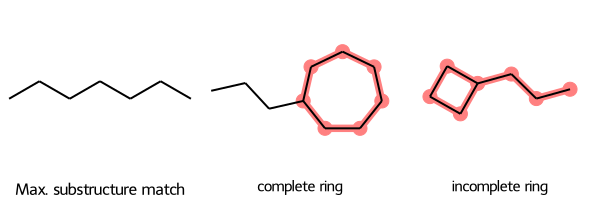

In [38]:
SmilesMCStoGridImage({"C1CCCCCC1CCC": "complete ring", "C1CCC1CCC": "incomplete ring"}, align_substructure=False)

`rdFMCS.FindMCS` lets you set the flag `completeRingsOnly=True` to avoid matching these two molecules. You can call `SmilesMCStoGridImage` with `completeRingsOnly=True` to pass that flag to `rdFMCS.FindMCS` so that the two molecules won't produce a match:

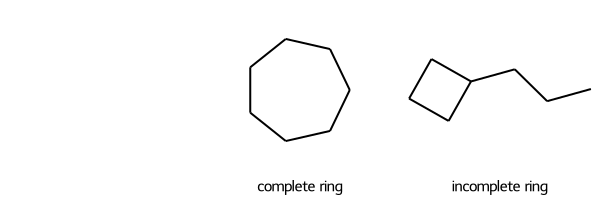

In [39]:
SmilesMCStoGridImage({"C1CCCCCC1": "complete ring", "C1CCC1CCC": "incomplete ring"}, align_substructure=False, completeRingsOnly=True)

## Example With Larger Molecules

As a final example, here's a case with larger molecules:

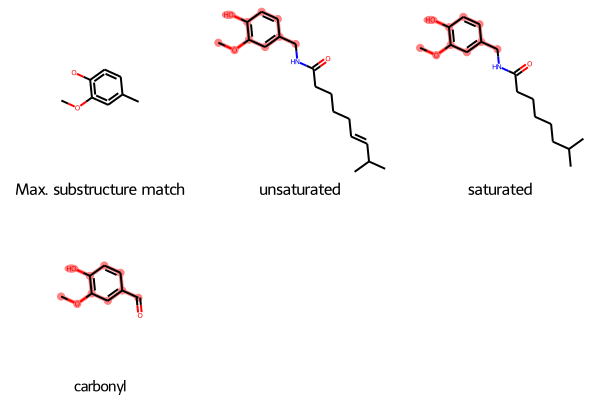

In [40]:
SmilesMCStoGridImage({"O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C": "unsaturated", "CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC": "saturated", "c1(C=O)cc(OC)c(O)cc1": "carbonyl"})